In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import fnmatch
import csv
import pickle
import warnings
import torch
import time
import multiprocessing as mp
from multiprocess import Pool
from multiprocess import Process
from copy import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

<Figure size 432x288 with 0 Axes>

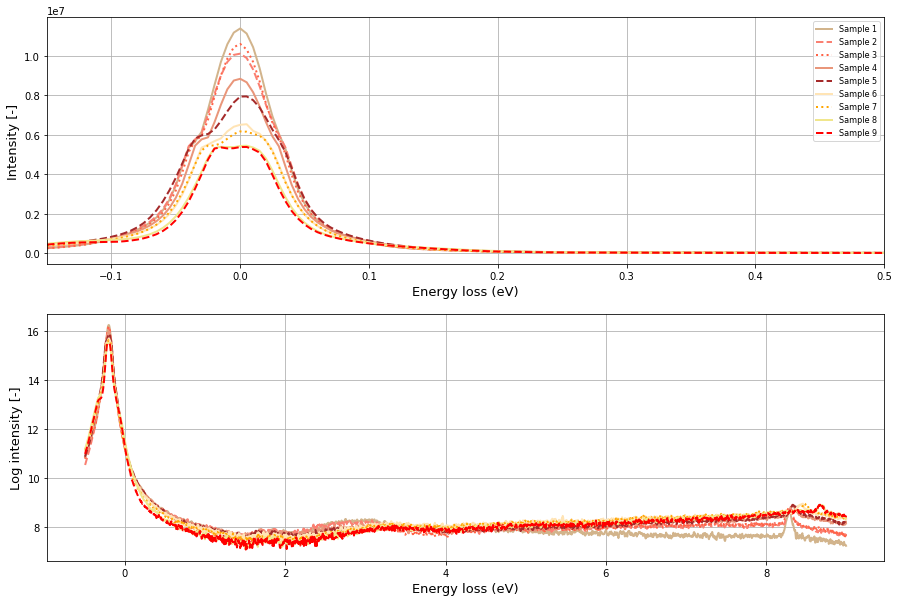

In [3]:
%run EELS-ZLP-May.py


With 1000 bins, the minimum number of training points within each bin is 9 and maximum is 18


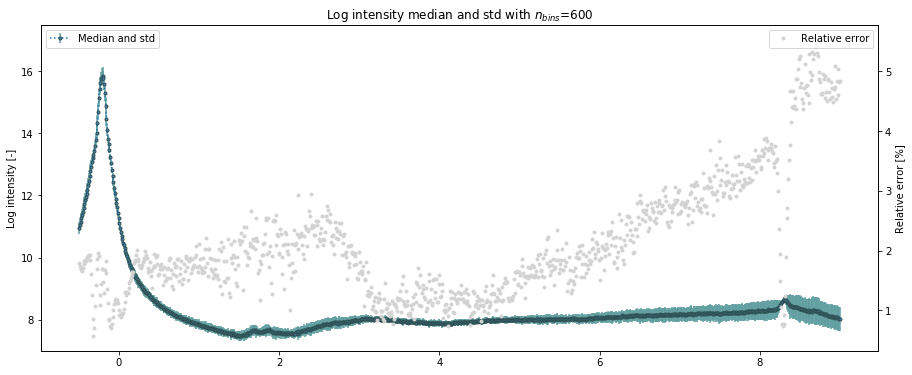

In [4]:
%run Functions.ipynb
fig = plt.gcf()

x_train = np.concatenate((x1,x2,x3,x3,x5,x6,x7,x8,x9))
logy_train = np.concatenate((log_y1, log_y2, log_y3, log_y4, log_y5, log_y6, log_y7, log_y8, log_y9))
y_train = np.concatenate((y1,y2,y3,y4,y5,y6,y7,y8,y9))
nbins = 1000
minval = min(x_train)
maxval = max(x_train)

# Store output vectors for training
df_train_log, cuts1_log, cuts2_log = ewd(x_train, logy_train, nbins)
df_train, cuts1_log, cuts2_log = ewd(x_train, y_train, nbins)
mean_log, std_log, count_log= binned_statistics(x_train, logy_train, nbins)[0:3]
mean_y, std_y, count_y= binned_statistics(x_train, y_train, nbins)[0:3]
variance_vector_log = vectorize_variance(x_train, logy_train, nbins)
variance_vector_y = vectorize_variance(x_train, y_train, nbins)
mean_vector_log = vectorize_mean(x_train, logy_train, nbins)
mean_vector_y = vectorize_mean(x_train, y_train, nbins)

# create one vector with (x_train, y_train, sigma_train)
print("With", nbins, "bins, the minimum number of training points within each bin is", int(min(count_log)), "and maximum is", int(max(count_log)))
# Create a plot of the mean & std 
plot_uncertainties(x_train, logy_train, nbins, minval, maxval)
plt.ylabel('Log intensity [-]')
ax2 = plt.twinx()
ax2.plot(np.linspace(minval, maxval, nbins), 100*np.divide(std_log, mean_log), '.', color='lightgray',  label='Relative error')
#ax2.plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend(['Relative error'], loc='upper right')
fig.set_size_inches(15, 6)
plt.title('Log intensity median and std with $n_{bins}$=600')
plt.xlabel('Energy loss [eV]')
plt.ylabel('Relative error [%]')
plt.show()
df_x = df_train[:,0]



In [5]:
df = pd.DataFrame()

df['x'] = df_x + 0.2025 # shift to align peak with zero loss
df['y'] = mean_vector_y
df['y_norm'] = df['y'] / df['y'].max()
df['log_y'] = np.log(mean_vector_y)
df['sigma'] = variance_vector_log
df['sigma_norm'] = variance_vector_log
df['real sigma'] = variance_vector_y

df

,x,y,y_norm,log_y,sigma,sigma_norm,real sigma
0,-0.295,57944.627778,0.007262,10.967243,0.196614,0.196614,10897.058950
1,-0.295,57944.627778,0.007262,10.967243,0.196614,0.196614,10897.058950
2,-0.295,57944.627778,0.007262,10.967243,0.196614,0.196614,10897.058950
3,-0.295,57944.627778,0.007262,10.967243,0.196614,0.196614,10897.058950
4,-0.295,57944.627778,0.007262,10.967243,0.196614,0.196614,10897.058950
...,...,...,...,...,...,...,...
17095,9.200,3285.278889,0.000412,8.097207,0.387920,0.387920,1062.049968
17096,9.200,3285.278889,0.000412,8.097207,0.387920,0.387920,1062.049968
17097,9.200,3285.278889,0.000412,8.097207,0.387920,0.387920,1062.049968
17098,9.200,3285.278889,0.000412,8.097207,0.387920,0.387920,1062.049968


## import vacuum spectra

In [9]:
%run Functions.ipynb

df_vacuum = pd.read_csv('Data/vacuumpeaks', sep=',')
df_vacuum = df_vacuum.drop('Unnamed: 0', axis=1)

df_vacuum

,x,y,mean_y,y_norm,sigma,sigma_norm
0,-0.298688,620.5810,648.236273,0.001901,106.047466,0.000760
1,-0.295774,659.2440,648.236273,0.002019,106.047466,0.000760
2,-0.292859,764.7210,648.236273,0.002342,106.047466,0.000760
3,-0.289945,854.2540,648.236273,0.002617,106.047466,0.000760
4,-0.287031,839.7260,648.236273,0.002572,106.047466,0.000760
...,...,...,...,...,...,...
4608,0.480720,146.7680,187.314667,0.000190,73.150271,0.000225
4609,0.485151,80.1585,187.314667,0.000104,73.150271,0.000225
4610,0.489582,154.2220,187.314667,0.000200,73.150271,0.000225
4611,0.494012,167.1390,187.314667,0.000217,73.150271,0.000225


## Gaussian fit

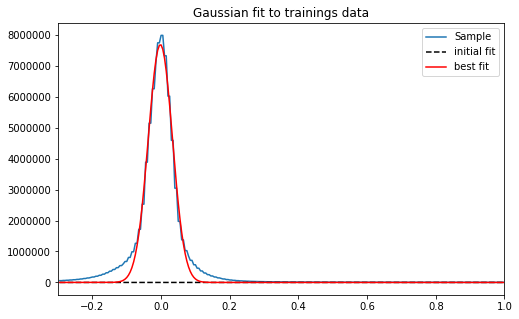

In [10]:
from lmfit import Model

def gaussian(x, amp, cen, std):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp) * np.exp(-(x-cen)**2 / (2*std**2))

gmodel = Model(gaussian)

gaussian_y = gmodel.fit(df['y'], x=df['x'], amp=1, cen=0, std=0.4)
amp10, cen10, std10 = gaussian_y.params['amp'].value, gaussian_y.params['cen'].value, gaussian_y.params['std'].value 

plt.figure(figsize=(8,5))
plt.title('Gaussian fit to trainings data')
plt.plot(df['x'], df['y'], label='Sample')
plt.plot(df['x'], gaussian_y.init_fit, 'k--', label='initial fit')
plt.plot(df['x'], gaussian_y.best_fit, 'r-', label='best fit')
plt.xlim([-.3,1])
plt.legend()

df['gaussian'] = gaussian_y.best_fit


## Closure test

In [11]:
df_closure = df.copy()

df_closure['smooth'] = smooth(df_closure['y'])
df_closure['pseudo'] = df_closure['smooth'] + df_closure['real sigma'] * np.random.rand(1)

df_closure = df_closure[df_closure['x']<1]
df_closure = df_closure.drop_duplicates()
df_closure.describe()

,x,y,y_norm,log_y,sigma,sigma_norm,real sigma,gaussian,smooth,pseudo
count,1207.000000,1.207000e+03,1207.000000,1207.000000,1207.000000,1207.000000,1.207000e+03,1.207000e+03,1.207000e+03,1.207000e+03
mean,0.352361,5.996834e+05,0.075161,10.600055,0.159497,0.159497,1.300985e+05,5.273796e+05,5.997061e+05,6.479397e+05
std,0.371971,1.603282e+06,0.200946,2.329251,0.044569,0.044569,3.775135e+05,1.618199e+06,1.599685e+06,1.737783e+06
min,-0.295000,3.100925e+03,0.000389,8.039456,0.075932,0.075932,3.551301e+02,1.427788e-168,3.080212e+03,3.211875e+03
25%,0.030000,5.268694e+03,0.000660,8.569538,0.130620,0.130620,7.196505e+02,2.035617e-74,5.294211e+03,5.592462e+03
50%,0.355000,1.622516e+04,0.002034,9.694318,0.149731,0.149731,2.149292e+03,2.961925e-16,1.655621e+04,1.735305e+04
75%,0.675000,2.311658e+05,0.028973,12.350891,0.176597,0.176597,3.681965e+04,1.845370e+02,2.251167e+05,2.418232e+05
max,0.995000,7.978663e+06,1.000000,15.892281,0.288361,0.288361,2.114322e+06,7.669816e+06,7.978663e+06,8.762541e+06


## Get the derivatives

In [120]:
window_len = 100
df_dx = pd.DataFrame({"x": x1, "y1": smooth(y1, window_len), "y2": smooth(y2, window_len), "y3": smooth(y3, window_len),\
                      "y4": smooth(y4, window_len), "y5": smooth(y5, window_len), "y6": smooth(y6, window_len), \
                      "y7": smooth(y7, window_len), "y8": smooth(y8, window_len), "y9": smooth(y9, window_len)})
window_len = 800
for i in range(1,9):
    df_dx['log y%(i)s' %{"i": i}] = np.log(df_dx['y%(i)s'% {"i": i}])
    df_dx['derivative y%(i)s' %{"i": i}] = np.divide(df_dx['y%(i)s'% {"i": i}].diff(), df_dx['x'].diff())
    df_dx['smooth derivative y%(i)s' %{"i": i}] = smooth(df_dx['derivative y%(i)s' %{"i": i}], window_len)
    df_dx['log derivative y%(i)s' %{"i": i}] = np.divide(df_dx['log y%(i)s'% {"i": i}].diff(), df_dx['x'].diff())
    df_dx['smooth log derivative y%(i)s' %{"i": i}] = smooth(df_dx['log derivative y%(i)s' %{"i": i}], window_len)
    df_dx['2nd derivative y%(i)s' %{"i": i}] = np.divide(df_dx['derivative y%(i)s'% {"i": i}].diff(), df_dx['x'].diff())
    df_dx['2nd log derivative y%(i)s' %{"i": i}] = np.divide(df_dx['log derivative y%(i)s'% {"i": i}].diff(), df_dx['x'].diff())   

li = []
for i in range(1,9):
    dE2 = df_dx[(df_dx['log derivative y%(i)s' %{"i": i}] > 0) & (df_dx['x'] > 0)]['x'].min()
    li.append(dE2)
    
dE2 = min(li) * 2

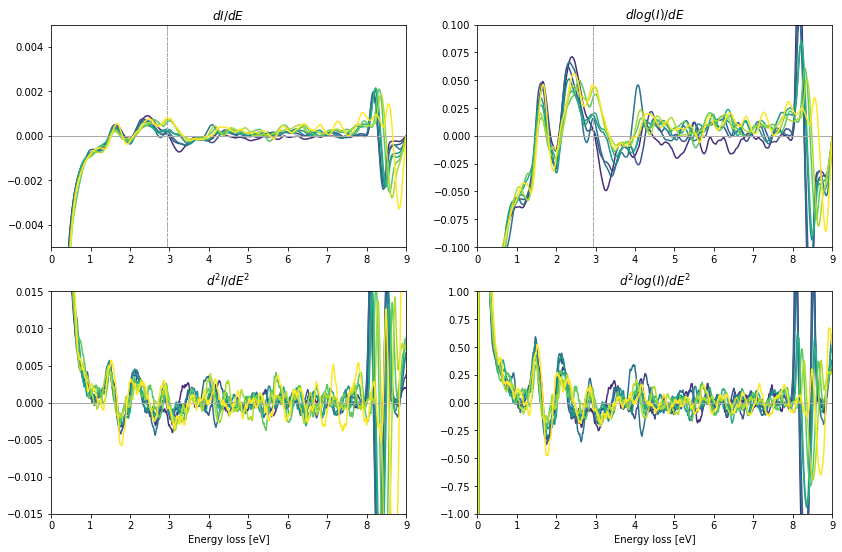

In [121]:
from matplotlib import cm
cm_subsection = np.linspace(0,1,9) 
colors = [cm.viridis(x) for x in cm_subsection ]

plt.figure(figsize=(14,9))
for i in range(1,9):
    plt.subplot(221)
    normalization = df_dx['y%(s)s' %{"s": i}].max()
    plt.axhline(y=0, color='darkgray', linewidth=1)
    plt.axvline(x=dE2, color='darkgray', linestyle='--', linewidth = 1, label='dE2')
    lognormalization = df_dx['log y%(s)s' %{"s": i}].max()
    plt.plot(df_dx['x'],df_dx['derivative y%(i)s' %{"i": i}]/normalization, color=colors[i])
    plt.title('$dI/dE$')
    plt.xlim([0,9])
    plt.ylim([-.005, .005])
    
    plt.subplot(222)
    plt.axhline(y=0, color='darkgray', linewidth=1)
    plt.axvline(x=dE2, color='darkgray', linestyle='--', linewidth = 1, label='dE2')
    plt.plot(df_dx['x'],df_dx['log derivative y%(i)s' %{"i": i}]/lognormalization, color=colors[i])
    plt.title('$dlog(I)/dE$')
    plt.xlim([0,9])
    plt.ylim([-.1, .1])
    
    
    plt.subplot(223)
    plt.axhline(y=0, color='darkgray', linewidth=1)
    #plt.axvline(x=dE2, color='darkgray', linestyle='--', linewidth = 1, label='dE2')
    plt.plot(df_dx['x'],df_dx['2nd derivative y%(i)s' %{"i": i}]/normalization, color=colors[i])
    plt.title('$d^2I/dE^2$')
    plt.xlim([0,9])
    plt.ylim([-.015, .015])
    plt.xlabel('Energy loss [eV]')
    
    
    plt.subplot(224)
    plt.axhline(y=0, color='darkgray', linewidth=1)
    #plt.axvline(x=dE2, color='darkgray', linestyle='--', linewidth = 1, label='dE2')
    plt.plot(df_dx['x'],df_dx['2nd log derivative y%(i)s' %{"i": i}]/lognormalization, color=colors[i])
    plt.title('$d^2log(I)/dE^2$')
    plt.xlim([0,9])
    plt.ylim([-1, 1])
    plt.xlabel('Energy loss [eV]')
    
plt.savefig('Figures/derivatives.png')    

## Mirroring

In [41]:
df_mirrored = df[df['x'] <  - df['x'].min()+.005]
df_mirrored['y_mirr'] = df['y'][::-1]
df_mirrored['y_mirr'] = df_mirrored['y_mirr'].values[::-1]
df_mirrored = df_mirrored.drop(['gaussian', 'y_norm', 'sigma_norm'], axis=1).drop_duplicates()
df_mirrored

,x,y,log_y,sigma,real sigma,y_mirr
0,-0.295,57944.627778,10.967243,0.196614,10897.058950,25311.644444
9,-0.290,57944.627778,10.967243,0.196614,10897.058950,27633.766667
18,-0.285,64671.600000,11.077077,0.193324,12025.115031,27633.766667
27,-0.280,64671.600000,11.077077,0.193324,12025.115031,30368.411111
36,-0.275,71509.244444,11.177582,0.188881,13046.468837,30368.411111
...,...,...,...,...,...,...
1026,0.275,30368.411111,10.321158,0.116693,3325.975965,71509.244444
1035,0.280,30368.411111,10.321158,0.116693,3325.975965,64671.600000
1044,0.285,27633.766667,10.226794,0.133090,3382.767385,64671.600000
1053,0.290,27633.766667,10.226794,0.133090,3382.767385,57944.627778


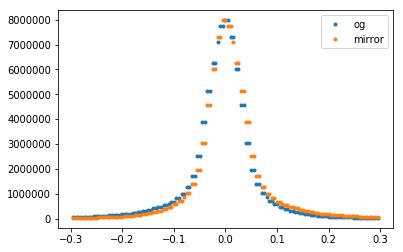

In [44]:
plt.plot(df_mirrored['x'], df_mirrored['y'], '.', label='og')
plt.plot(df_mirrored['x'], df_mirrored['y_mirr'], '.', label='mirror')
plt.legend()

## dE1 and dE2

The value of dE2 is calculated as the first time the derivative dI/dE grows to zero.

In [29]:
dE1 = dE2 / 2
dE1 += .2
print('The values of dE1 and dE2', dE1, dE2)

The values of dE1 and dE2 1.6675000000000002 2.9350000000000005


### Drop data for x > dE1



In [30]:
df_window = df[df['x'] <= dE1]

In [31]:
df_window.describe()

,x,y,log_y,sigma,real sigma,gaussian
count,3537.000000,3.537000e+03,3537.000000,3537.000000,3.537000e+03,3.537000e+03
mean,0.685000,3.925556e+05,9.632519,0.152189,8.526589e+04,3.445516e+05
std,0.567325,1.320069e+06,2.318818,0.039113,3.100686e+05,1.324330e+06
min,-0.295000,1.791709e+03,7.490925,0.075932,1.714286e+02,0.000000e+00
25%,0.195000,2.625206e+03,7.872914,0.128102,3.551301e+02,2.380101e-237
50%,0.685000,5.081021e+03,8.533267,0.144639,6.684598e+02,8.150242e-77
75%,1.175000,6.720752e+04,11.115540,0.164834,1.089706e+04,1.421194e-04
max,1.665000,7.978663e+06,15.892281,0.288361,2.114322e+06,7.669816e+06


###  Find the value where the tail intensity is at $10^{-3}$ of its maximum

This is also known as the 'Kimoto Limit'.

In [32]:
kimoto_lim = max(df[df['y'] > (1e-3) * max(df['y'])]['x'])
kimoto_lim

0.5100000000000001

### Create pseudo data for $x > $dE2

In [33]:
min_x = dE2
max_x = 8.9975
N_pseudo = 30

df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y': 3 * np.ones(N_pseudo), \
                    'log_y': np.log(3 * np.ones(N_pseudo)), 'sigma': .2 * np.ones(N_pseudo)})



In [34]:
#df_full = df_window

df_full = pd.concat([df_window, df_pseudo])

df_full.describe()

,gaussian,log_y,real sigma,sigma,x,y
count,3.537000e+03,3567.000000,3.537000e+03,3567.000000,3567.000000,3.567000e+03
mean,3.445516e+05,9.560745,8.526589e+04,0.152592,0.729418,3.892541e+05
std,1.324330e+06,2.437050,3.100686e+05,0.039192,0.761161,1.314993e+06
min,0.000000e+00,1.098612,1.714286e+02,0.075932,-0.295000,3.000000e+00
25%,2.380101e-237,7.868067,3.551301e+02,0.128102,0.200000,2.612510e+03
50%,8.150242e-77,8.512335,6.684598e+02,0.144748,0.695000,4.975767e+03
75%,1.421194e-04,11.077077,1.089706e+04,0.165407,1.190000,6.467160e+04
max,7.669816e+06,15.892281,2.114322e+06,0.288361,8.997500,7.978663e+06


### Create architecture

In [35]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [36]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 1], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_train_full = df_full
df_train_full = df_train_full.drop_duplicates(subset = ['x']) # Only keep one copy per x-value
df_train, df_test = train_test_split(df_train_full, test_size=0.18, random_state=26)

N_train = len(df_train['x'])
N_test = len(df_test['x'])

train_x = np.copy(df_train['x']).reshape(N_train,1)
train_y = np.log(np.copy(df_train['y'])).reshape(N_train,1)
train_sigma = (np.copy(df_train['sigma'])).reshape(N_train,1)

test_x = np.copy(df_test['x']).reshape(N_test,1)
test_y = np.log(np.copy(df_test['y'])).reshape(N_test,1)
test_sigma = (np.copy(df_test['sigma'])).reshape(N_test,1)

predictions = make_model(x,1)
N_pred = 30000
predict_x = np.linspace(-.3,8.9975,N_pred).reshape(N_pred,1)

#train_scaler = StandardScaler()
#train_scaler.fit(train_x)
#test_scaler = StandardScaler()
#test_scaler.fit(test_x)
train_sigma.shape

(346, 1)

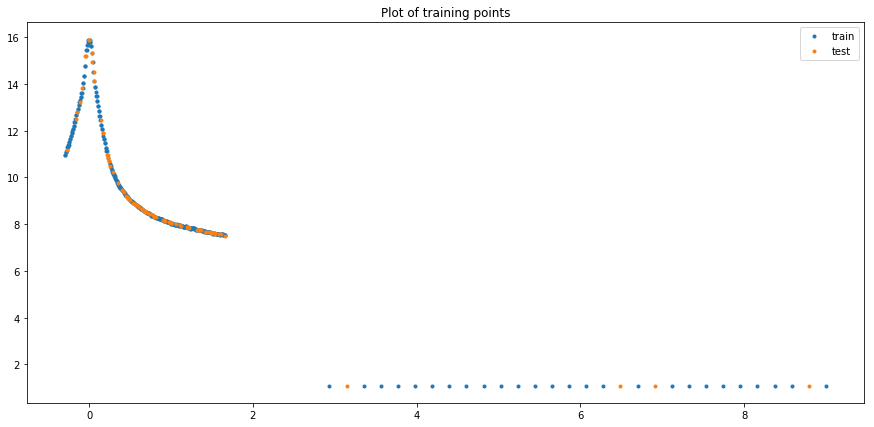

In [37]:
plt.figure(figsize=(15,7))
#plt.xlim([-0.35, -0.2])
plt.plot(train_x, train_y, '.', label='train')
plt.plot(test_x, test_y, '.', label='test')
plt.title('Plot of training points')
plt.legend()

## Create MC replicas

In [38]:
### Create array of Nrep training samples

def pseudodata(Nrep):
    
    train_y_reps = np.zeros(shape=(N_train, Nrep))
    test_y_reps = np.zeros(shape=(N_test, Nrep))
    i=0
    while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)

        i+=1 
    train_y_reps[train_y_reps < .1] = .1    
    test_y_reps[test_y_reps < .1] = .1
    std_reps = np.std(train_y_reps, axis=1)
    mean_reps = np.mean(train_y_reps, axis=1)
    
    return mean_reps, std_reps

mean_reps100, std_reps100 = pseudodata(100)
mean_reps500, std_reps500 = pseudodata(500)
mean_reps1000, std_reps1000 = pseudodata(1000)
mean_reps5000, std_reps5000 = pseudodata(5000)

In [39]:
exp100 = np.mean(mean_reps100[mean_reps100 > 5])
exp500 = np.mean(mean_reps500[mean_reps500 > 5])
exp1000 = np.mean(mean_reps1000[mean_reps1000 > 5])
exp5000 = np.mean(mean_reps5000[mean_reps5000 > 5])
exp = np.mean(train_y[train_y > 5])

std100 = np.mean(std_reps100)
std500 = np.mean(std_reps500)
std1000 = np.mean(std_reps1000)
std5000 = np.mean(std_reps5000)
std = np.mean(train_sigma)



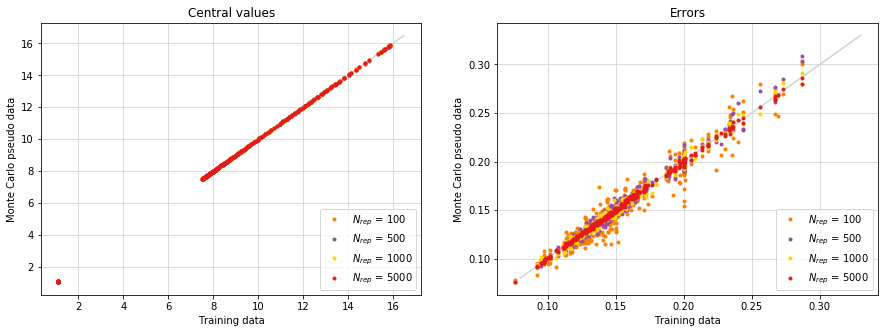

In [40]:
plt.figure(figsize=(15,5))
from matplotlib import cm
cm_subsection = np.linspace(0,1,7) 
colors = [ cm.Set1(x) for x in cm_subsection ]

plt.subplot(121)
plt.title('Central values')
plt.plot(np.linspace(7.5,16.5,10), np.linspace(7.5,16.5,10), color='lightgrey')

plt.plot(train_y, mean_reps100, '.', color = colors[3], label = '$N_{rep}$ = 100')
plt.plot(train_y, mean_reps500, '.', color = colors[2], label = '$N_{rep}$ = 500')
plt.plot(train_y, mean_reps1000, '.', color = 'gold', label = '$N_{rep}$ = 1000')
plt.plot(train_y, mean_reps5000, '.', color = colors[0], label = '$N_{rep}$ = 5000')
plt.grid(True, color='lightgray')
#plt.xlim([7,17])
#plt.ylim([7,17])
plt.xlabel(r'Training data')
plt.legend(loc='lower right')
plt.ylabel(r'Monte Carlo pseudo data')

plt.subplot(122)
plt.grid(True, color='lightgray')
plt.title('Errors')
plt.plot(np.linspace(0.08,0.33,10), np.linspace(0.08,0.33,10), color='lightgrey')
plt.plot(train_sigma, std_reps100, '.', color=colors[3], label = '$N_{rep}$ = 100')
plt.plot(train_sigma, std_reps500, '.', color=colors[2], label = '$N_{rep}$ = 500')
plt.plot(train_sigma, std_reps1000, '.', color='gold', label = '$N_{rep}$ = 1000')
plt.plot(train_sigma, std_reps5000, '.', color=colors[0], label = '$N_{rep}$ = 5000')
plt.xlabel(r'Training data')
plt.legend(loc='lower right')
#plt.xlim([0.07, 0.35])
#plt.ylim([0.07, 0.35])
plt.ylabel(r'Monte Carlo pseudo data')

plt.show()

In [41]:
Nrep = 5000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

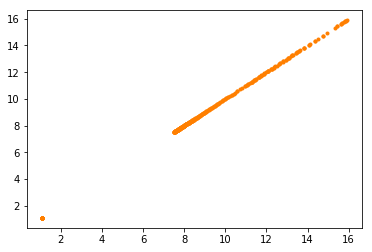

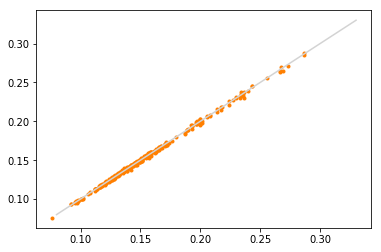

In [42]:
plt.plot(train_y, mean_reps, '.', color = colors[3], label = '$N_{rep}$ = 100')
plt.show()
plt.plot(train_sigma, std_reps, '.', color = colors[3], label = '$N_{rep}$ = 100')
plt.plot(np.linspace(0.08,0.33,10), np.linspace(0.08,0.33,10), color='lightgrey')
plt.show()

In [44]:
import time
from datetime import datetime


def function_train(it):
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 1e-3
    optimizer = tf.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=eta)
    saver = tf.train.Saver(max_to_keep=40)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 30

    for i in range(Nrep):

        train_y = train_y_reps[:, i+50 + it].reshape(N_train,1)
        test_y = test_y_reps[:, i+50 + it].reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []

        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 40000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma
                                })

                avg_cost = c
                
                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 

                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            

            saver.restore(sess, best_model)

            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 


            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        now = datetime.now()

        dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
        d_string = now.strftime("%d.%m.%Y")
        t_string = now.strftime("%H:%M:%S")

        a = np.array(train_x).reshape(N_train,)
        b = np.array(train_y).reshape(N_train,)
        c = np.array(predictions_values).reshape(N_train,)
        d = array_train
        e = array_test
       
        k = np.array(predict_x).reshape(N_pred,)
        l = np.array(extrapolation).reshape(N_pred,)
        
        np.savetxt('Data/Results/%(date)s/x2_xyp1p2_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i+10 }, list(zip(a,b,c)),  delimiter=',', fmt='%f')
        np.savetxt('Data/Results/%(date)s/x2_chi_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i +10}, list(zip(d,e)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/%(date)s/x2_extrapolation_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i +10}, list(zip(k, l)),  delimiter=',', fmt='%f')
 

## Parallel training

In [45]:
# make sure to always use multiprocess
from multiprocess import Pool
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

number_of_cores=6
# start your parallel workers at the beginning of your script
pool = Pool(number_of_cores)

# execute a computation(s) in parallel
result1 = pool.map(function_train, [1,2,3,4,5,6])

pool.close()

#print(pool)


processor1 starts training on 0346 and validating on 0077 samples
processor3 starts training on 0346 and validating on 0077 samples
processor6 starts training on 0346 and validating on 0077 samples
processor4 starts training on 0346 and validating on 0077 samples
processor2 starts training on 0346 and validating on 0077 samples
processor5 starts training on 0346 and validating on 0077 samples
Epoch: 0001 | Training cost= 4854.495605469 | Validation cost= 4517.230468750
Epoch: 0001 | Training cost= 4856.355957031 | Validation cost= 4483.746582031
Epoch: 0001 | Training cost= 4843.802246094 | Validation cost= 4508.632324219
Epoch: 0001 | Training cost= 4843.087402344 | Validation cost= 4525.432617188
Epoch: 0001 | Training cost= 4853.634277344 | Validation cost= 4502.203613281
Epoch: 0001 | Training cost= 4847.498046875 | Validation cost= 4518.006347656
Epoch: 1001 | Training cost= 48.618293762 | Validation cost= 45.454753876
Epoch: 1001 | Training cost= 48.069335938 | Validation cost= 4

Epoch: 17001 | Training cost= 1.285144091 | Validation cost= 1.150617123
Epoch: 18001 | Training cost= 0.944524229 | Validation cost= 1.071357012
Epoch: 18001 | Training cost= 1.166298628 | Validation cost= 1.281728983
Epoch: 18001 | Training cost= 1.032229543 | Validation cost= 0.999022067
Epoch: 18001 | Training cost= 1.033334255 | Validation cost= 1.155228496
Epoch: 18001 | Training cost= 1.254047990 | Validation cost= 1.390496492
Epoch: 18001 | Training cost= 1.274177194 | Validation cost= 1.148951173
Epoch: 19001 | Training cost= 0.932041407 | Validation cost= 1.075639129
Epoch: 19001 | Training cost= 1.170353413 | Validation cost= 1.285750389
Epoch: 19001 | Training cost= 1.033418655 | Validation cost= 1.000928164
Epoch: 19001 | Training cost= 1.028330684 | Validation cost= 1.153416634
Epoch: 19001 | Training cost= 1.250754952 | Validation cost= 1.390498996
Epoch: 19001 | Training cost= 1.268654704 | Validation cost= 1.144747972
Epoch: 20001 | Training cost= 1.167445302 | Validat

Epoch: 36001 | Training cost= 1.209722400 | Validation cost= 1.383657932
Epoch: 36001 | Training cost= 0.932635725 | Validation cost= 1.070681930
Epoch: 37001 | Training cost= 1.166602731 | Validation cost= 1.310366511
Epoch: 37001 | Training cost= 1.003958344 | Validation cost= 1.142469883
Epoch: 37001 | Training cost= 1.237508416 | Validation cost= 1.133645058
Epoch: 37001 | Training cost= 1.001821637 | Validation cost= 1.023936033
Epoch: 37001 | Training cost= 1.208800793 | Validation cost= 1.385497928
Epoch: 37001 | Training cost= 0.927393675 | Validation cost= 1.072867393
Epoch: 38001 | Training cost= 1.163902879 | Validation cost= 1.308101654
Epoch: 38001 | Training cost= 1.002738476 | Validation cost= 1.146022439
Epoch: 38001 | Training cost= 1.000028372 | Validation cost= 1.023211598
Epoch: 38001 | Training cost= 1.238367438 | Validation cost= 1.134584546
Epoch: 38001 | Training cost= 1.206858635 | Validation cost= 1.386507750
Epoch: 38001 | Training cost= 0.941105306 | Validat

Epoch: 8001 | Training cost= 2.052673578 | Validation cost= 2.011943579
Epoch: 9001 | Training cost= 1.737904668 | Validation cost= 1.111084819
Epoch: 9001 | Training cost= 1.540997982 | Validation cost= 1.484054208
Epoch: 9001 | Training cost= 1.634383559 | Validation cost= 1.468225479
Epoch: 9001 | Training cost= 1.744235754 | Validation cost= 1.657799721
Epoch: 9001 | Training cost= 1.771481156 | Validation cost= 1.657325506
Epoch: 9001 | Training cost= 1.703650117 | Validation cost= 1.524838567
Epoch: 10001 | Training cost= 1.501796246 | Validation cost= 1.033226132
Epoch: 10001 | Training cost= 1.350428104 | Validation cost= 1.337199688
Epoch: 10001 | Training cost= 1.468669176 | Validation cost= 1.284287333
Epoch: 10001 | Training cost= 1.570128918 | Validation cost= 1.515061855
Epoch: 10001 | Training cost= 1.594787955 | Validation cost= 1.479967356
Epoch: 10001 | Training cost= 1.529200792 | Validation cost= 1.446871281
Epoch: 11001 | Training cost= 1.399420023 | Validation cos

Epoch: 27001 | Training cost= 1.234646797 | Validation cost= 1.281505346
Epoch: 27001 | Training cost= 1.237578273 | Validation cost= 1.177353621
Epoch: 28001 | Training cost= 1.082652330 | Validation cost= 0.944434524
Epoch: 28001 | Training cost= 1.128325582 | Validation cost= 0.958949804
Epoch: 28001 | Training cost= 0.991986036 | Validation cost= 1.059464574
Epoch: 28001 | Training cost= 1.244014978 | Validation cost= 1.106974125
Epoch: 28001 | Training cost= 1.232924223 | Validation cost= 1.284480691
Epoch: 28001 | Training cost= 1.236115694 | Validation cost= 1.178014636
Epoch: 29001 | Training cost= 1.079400420 | Validation cost= 0.946159482
Epoch: 29001 | Training cost= 0.990365624 | Validation cost= 1.061182261
Epoch: 29001 | Training cost= 1.126991391 | Validation cost= 0.961623430
Epoch: 29001 | Training cost= 1.242666841 | Validation cost= 1.104361296
Epoch: 29001 | Training cost= 1.234436035 | Validation cost= 1.177420378
Epoch: 29001 | Training cost= 1.229888082 | Validat

Epoch: 4001 | Training cost= 1600.643554688 | Validation cost= 1427.911376953
Epoch: 4001 | Training cost= 1597.196899414 | Validation cost= 1416.245239258
Epoch: 4001 | Training cost= 1600.039062500 | Validation cost= 1420.575195312
Epoch: 4001 | Training cost= 1601.671630859 | Validation cost= 1426.959350586
Epoch: 5001 | Training cost= 1156.378417969 | Validation cost= 981.229003906
Epoch: 5001 | Training cost= 1152.396728516 | Validation cost= 997.415466309
Epoch: 5001 | Training cost= 1155.721679688 | Validation cost= 998.384765625
Epoch: 5001 | Training cost= 1149.644287109 | Validation cost= 987.628967285
Epoch: 5001 | Training cost= 1152.341430664 | Validation cost= 990.432861328
Epoch: 5001 | Training cost= 1153.519653320 | Validation cost= 996.138488770
Epoch: 6001 | Training cost= 804.529602051 | Validation cost= 651.648864746
Epoch: 6001 | Training cost= 801.538574219 | Validation cost= 664.604797363
Epoch: 6001 | Training cost= 804.091430664 | Validation cost= 665.80303955

Epoch: 22001 | Training cost= 331.017395020 | Validation cost= 252.214233398
Epoch: 22001 | Training cost= 331.171844482 | Validation cost= 254.269531250
Epoch: 22001 | Training cost= 331.115966797 | Validation cost= 250.005523682
Epoch: 22001 | Training cost= 333.217956543 | Validation cost= 246.575973511
Epoch: 22001 | Training cost= 332.530273438 | Validation cost= 249.563659668
Epoch: 23001 | Training cost= 330.931640625 | Validation cost= 249.533096313
Epoch: 23001 | Training cost= 331.017395020 | Validation cost= 252.214233398
Epoch: 23001 | Training cost= 333.217956543 | Validation cost= 246.575973511
Epoch: 23001 | Training cost= 331.171844482 | Validation cost= 254.269531250
Epoch: 23001 | Training cost= 331.115966797 | Validation cost= 250.005523682
Epoch: 23001 | Training cost= 332.530273438 | Validation cost= 249.563659668
Epoch: 24001 | Training cost= 330.931640625 | Validation cost= 249.533096313
Epoch: 24001 | Training cost= 331.017395020 | Validation cost= 252.214233398

Optimization 2 Finished! Best model after epoch 9000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-9000
Optimization 2 Finished! Best model after epoch 9000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-9000
Optimization 2 Finished! Best model after epoch 9000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-9000
Epoch: 0001 | Training cost= 3566.295410156 | Validation cost= 3278.001464844
Optimization 2 Finished! Best model after epoch 9000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-9000
Optimization 2 Finished! Best model after epoch 9000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-9000
Optimization 2 Finished! Best model after epoch 9000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-9000
Epoch: 0001 | Training cost= 3572.697998047 | Validation cost= 3308.972412109
Epoch: 0001 | Training cost= 3578.333007812 | Valida

Epoch: 16001 | Training cost= 3.545090199 | Validation cost= 4.248956680
Epoch: 17001 | Training cost= 3.362642288 | Validation cost= 3.647050381
Epoch: 17001 | Training cost= 3.579409599 | Validation cost= 3.934081316
Epoch: 17001 | Training cost= 3.451501846 | Validation cost= 3.940933704
Epoch: 17001 | Training cost= 3.369257689 | Validation cost= 3.146588564
Epoch: 17001 | Training cost= 3.483033657 | Validation cost= 3.497376204
Epoch: 17001 | Training cost= 3.349036455 | Validation cost= 3.922497988
Epoch: 18001 | Training cost= 3.172735453 | Validation cost= 3.345358372
Epoch: 18001 | Training cost= 3.360363960 | Validation cost= 3.535382986
Epoch: 18001 | Training cost= 3.305415392 | Validation cost= 3.228792191
Epoch: 18001 | Training cost= 3.203480959 | Validation cost= 2.841278553
Epoch: 18001 | Training cost= 3.219464064 | Validation cost= 3.563425064
Epoch: 18001 | Training cost= 3.171234369 | Validation cost= 3.572063208
Epoch: 19001 | Training cost= 2.999246120 | Validat

Epoch: 35001 | Training cost= 1.546082020 | Validation cost= 1.228634477
Epoch: 35001 | Training cost= 1.572579741 | Validation cost= 1.460023403
Epoch: 36001 | Training cost= 1.508179784 | Validation cost= 1.435964704
Epoch: 36001 | Training cost= 1.627304912 | Validation cost= 1.410343170
Epoch: 36001 | Training cost= 1.663032651 | Validation cost= 1.855470181
Epoch: 36001 | Training cost= 1.512538791 | Validation cost= 1.202049017
Epoch: 36001 | Training cost= 1.432472944 | Validation cost= 1.526917338
Epoch: 36001 | Training cost= 1.548053145 | Validation cost= 1.460016727
Epoch: 37001 | Training cost= 1.480721712 | Validation cost= 1.400631785
Epoch: 37001 | Training cost= 1.611836672 | Validation cost= 1.398696661
Epoch: 37001 | Training cost= 1.409905434 | Validation cost= 1.500591874
Epoch: 37001 | Training cost= 1.643132687 | Validation cost= 1.831407070
Epoch: 37001 | Training cost= 1.491202116 | Validation cost= 1.189061522
Epoch: 37001 | Training cost= 1.524281263 | Validat

Epoch: 12001 | Training cost= 1.217356801 | Validation cost= 1.181889772
Epoch: 12001 | Training cost= 1.203861713 | Validation cost= 0.921884000
Epoch: 12001 | Training cost= 1.259326100 | Validation cost= 1.155694723
Epoch: 13001 | Training cost= 1.145648003 | Validation cost= 1.086982727
Epoch: 13001 | Training cost= 1.185060978 | Validation cost= 1.078194737
Epoch: 13001 | Training cost= 1.162762284 | Validation cost= 0.879755676
Epoch: 13001 | Training cost= 1.205944061 | Validation cost= 1.173083544
Epoch: 13001 | Training cost= 1.183251977 | Validation cost= 0.917910099
Epoch: 13001 | Training cost= 1.244719028 | Validation cost= 1.134101033
Epoch: 14001 | Training cost= 1.135523200 | Validation cost= 1.080040812
Epoch: 14001 | Training cost= 1.171863675 | Validation cost= 1.066639304
Epoch: 14001 | Training cost= 1.150437474 | Validation cost= 0.881385207
Epoch: 14001 | Training cost= 1.196526527 | Validation cost= 1.167938828
Epoch: 14001 | Training cost= 1.162726402 | Validat

Epoch: 31001 | Training cost= 1.074981809 | Validation cost= 0.939099967
Epoch: 31001 | Training cost= 1.122896194 | Validation cost= 1.160875559
Epoch: 31001 | Training cost= 1.018869162 | Validation cost= 0.989517987
Epoch: 31001 | Training cost= 1.177386284 | Validation cost= 1.051664114
Epoch: 32001 | Training cost= 1.053402305 | Validation cost= 1.060811043
Epoch: 32001 | Training cost= 1.103823423 | Validation cost= 1.025013566
Epoch: 32001 | Training cost= 1.120281339 | Validation cost= 1.161611676
Epoch: 32001 | Training cost= 1.064000130 | Validation cost= 0.932889342
Epoch: 32001 | Training cost= 1.013108969 | Validation cost= 0.997450709
Epoch: 32001 | Training cost= 1.173655152 | Validation cost= 1.048553467
Epoch: 33001 | Training cost= 1.049028635 | Validation cost= 1.062387824
Epoch: 33001 | Training cost= 1.103811383 | Validation cost= 1.026601195
Epoch: 33001 | Training cost= 1.007183313 | Validation cost= 1.005504131
Epoch: 33001 | Training cost= 1.068738580 | Validat

Epoch: 8001 | Training cost= 8.843471527 | Validation cost= 7.845849037
Epoch: 8001 | Training cost= 10.211063385 | Validation cost= 10.045811653
Epoch: 8001 | Training cost= 10.367153168 | Validation cost= 9.204057693
Epoch: 8001 | Training cost= 10.952898979 | Validation cost= 9.792284012
Epoch: 8001 | Training cost= 10.616475105 | Validation cost= 10.879422188
Epoch: 9001 | Training cost= 7.753800392 | Validation cost= 8.965990067
Epoch: 9001 | Training cost= 5.515426159 | Validation cost= 5.324883461
Epoch: 9001 | Training cost= 6.891826630 | Validation cost= 7.489450455
Epoch: 9001 | Training cost= 6.910912037 | Validation cost= 6.712148666
Epoch: 9001 | Training cost= 7.416860104 | Validation cost= 7.531319141
Epoch: 9001 | Training cost= 7.210118294 | Validation cost= 8.453969955
Epoch: 10001 | Training cost= 5.800236702 | Validation cost= 7.397687435
Epoch: 10001 | Training cost= 3.650744438 | Validation cost= 3.592589140
Epoch: 10001 | Training cost= 4.803251266 | Validation c

Epoch: 26001 | Training cost= 1.320598483 | Validation cost= 1.205884576
Epoch: 27001 | Training cost= 1.158089757 | Validation cost= 1.031625986
Epoch: 27001 | Training cost= 1.172279000 | Validation cost= 1.149336100
Epoch: 27001 | Training cost= 1.150114655 | Validation cost= 1.233152747
Epoch: 27001 | Training cost= 1.110717416 | Validation cost= 1.185251355
Epoch: 28001 | Training cost= 1.333897114 | Validation cost= 1.507913113
Epoch: 27001 | Training cost= 1.313060164 | Validation cost= 1.196939111
Epoch: 28001 | Training cost= 1.150545716 | Validation cost= 1.032258153
Epoch: 28001 | Training cost= 1.166042209 | Validation cost= 1.147799611
Epoch: 28001 | Training cost= 1.140015364 | Validation cost= 1.230155826
Epoch: 28001 | Training cost= 1.101809859 | Validation cost= 1.180303454
Epoch: 29001 | Training cost= 1.308741808 | Validation cost= 1.487568736
Epoch: 28001 | Training cost= 1.306645870 | Validation cost= 1.189796209
Epoch: 29001 | Training cost= 1.143700838 | Validat

Epoch: 4001 | Training cost= 35.691879272 | Validation cost= 28.786027908
Epoch: 3001 | Training cost= 40.052822113 | Validation cost= 34.288112640
Epoch: 4001 | Training cost= 36.133773804 | Validation cost= 28.285644531
Epoch: 4001 | Training cost= 35.479751587 | Validation cost= 27.862318039
Epoch: 4001 | Training cost= 35.716205597 | Validation cost= 27.928859711
Epoch: 4001 | Training cost= 35.540981293 | Validation cost= 29.637493134
Epoch: 5001 | Training cost= 32.082439423 | Validation cost= 26.053800583
Epoch: 4001 | Training cost= 36.467044830 | Validation cost= 30.087072372
Epoch: 5001 | Training cost= 32.438579559 | Validation cost= 25.790422440
Epoch: 5001 | Training cost= 32.002666473 | Validation cost= 25.237890244
Epoch: 5001 | Training cost= 32.125484467 | Validation cost= 25.311588287
Epoch: 5001 | Training cost= 31.872180939 | Validation cost= 27.040063858
Epoch: 6001 | Training cost= 28.999076843 | Validation cost= 23.609685898
Epoch: 5001 | Training cost= 32.833610

Epoch: 22001 | Training cost= 1.187703729 | Validation cost= 1.231359720
Epoch: 22001 | Training cost= 1.281458974 | Validation cost= 1.079727292
Epoch: 23001 | Training cost= 1.175325394 | Validation cost= 1.155293703
Epoch: 22001 | Training cost= 1.179818869 | Validation cost= 1.215820551
Epoch: 23001 | Training cost= 1.273092747 | Validation cost= 1.123206496
Epoch: 23001 | Training cost= 1.186499238 | Validation cost= 1.582118869
Epoch: 23001 | Training cost= 1.190242887 | Validation cost= 1.232399344
Epoch: 23001 | Training cost= 1.271796465 | Validation cost= 1.071719646
Epoch: 23001 | Training cost= 1.168806791 | Validation cost= 1.194527268
Epoch: 24001 | Training cost= 1.166890860 | Validation cost= 1.146419644
Epoch: 24001 | Training cost= 1.262478948 | Validation cost= 1.107711673
Epoch: 24001 | Training cost= 1.182109594 | Validation cost= 1.572097301
Epoch: 24001 | Training cost= 1.175727844 | Validation cost= 1.221168995
Epoch: 24001 | Training cost= 1.264161348 | Validat

Epoch: 0001 | Training cost= 4417.239746094 | Validation cost= 4129.285156250
Optimization 6 Finished! Best model after epoch 28000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-28000
Optimization 6 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor2/my-model.ckpt-39000
Epoch: 0001 | Training cost= 4417.944824219 | Validation cost= 4133.947265625
Epoch: 0001 | Training cost= 4419.456054688 | Validation cost= 4127.113281250
Epoch: 0001 | Training cost= 4421.232910156 | Validation cost= 4143.720214844
Epoch: 0001 | Training cost= 4421.699218750 | Validation cost= 4119.152832031
Epoch: 0001 | Training cost= 4420.265136719 | Validation cost= 4142.607910156
Epoch: 1001 | Training cost= 48.397872925 | Validation cost= 45.218738556
Epoch: 1001 | Training cost= 49.090080261 | Validation cost= 45.781372070
Epoch: 1001 | Training cost= 49.410274506 | Validation cost= 48.236019135
Epoch: 1001 | Training cost= 49.506343842 

Epoch: 18001 | Training cost= 0.923412323 | Validation cost= 1.171110034
Epoch: 18001 | Training cost= 1.065601468 | Validation cost= 1.038771391
Epoch: 18001 | Training cost= 1.081312180 | Validation cost= 1.395745277
Epoch: 18001 | Training cost= 1.105704546 | Validation cost= 1.031437039
Epoch: 18001 | Training cost= 1.149532557 | Validation cost= 1.152706742
Epoch: 19001 | Training cost= 1.096562624 | Validation cost= 1.059251666
Epoch: 19001 | Training cost= 0.922125757 | Validation cost= 1.174309731
Epoch: 19001 | Training cost= 1.059071898 | Validation cost= 1.031249642
Epoch: 19001 | Training cost= 1.083400249 | Validation cost= 1.389935732
Epoch: 19001 | Training cost= 1.101619959 | Validation cost= 1.030568719
Epoch: 19001 | Training cost= 1.145731211 | Validation cost= 1.157284737
Epoch: 20001 | Training cost= 1.095495820 | Validation cost= 1.058321357
Epoch: 20001 | Training cost= 0.922565460 | Validation cost= 1.173362613
Epoch: 20001 | Training cost= 1.057255864 | Validat

Epoch: 37001 | Training cost= 1.074439764 | Validation cost= 1.078670263
Epoch: 37001 | Training cost= 0.903158903 | Validation cost= 1.195754290
Epoch: 37001 | Training cost= 1.073432922 | Validation cost= 1.390825033
Epoch: 37001 | Training cost= 0.983746588 | Validation cost= 1.092107058
Epoch: 37001 | Training cost= 1.091815352 | Validation cost= 1.034730315
Epoch: 37001 | Training cost= 1.092824817 | Validation cost= 1.197515368
Epoch: 38001 | Training cost= 1.072934151 | Validation cost= 1.079829693
Epoch: 38001 | Training cost= 0.901758909 | Validation cost= 1.196956515
Epoch: 38001 | Training cost= 0.980734944 | Validation cost= 1.102139950
Epoch: 38001 | Training cost= 1.078272700 | Validation cost= 1.423081875
Epoch: 38001 | Training cost= 1.085655570 | Validation cost= 1.032012582
Epoch: 38001 | Training cost= 1.087863922 | Validation cost= 1.206489444
Epoch: 39001 | Training cost= 1.070756197 | Validation cost= 1.081088662
Epoch: 39001 | Training cost= 0.899751067 | Validat

Epoch: 13001 | Training cost= 1.241201758 | Validation cost= 1.006411672
Epoch: 14001 | Training cost= 1.195224881 | Validation cost= 1.533002377
Epoch: 14001 | Training cost= 1.278915405 | Validation cost= 1.031355977
Epoch: 14001 | Training cost= 1.255205989 | Validation cost= 0.978579164
Epoch: 14001 | Training cost= 1.203986406 | Validation cost= 1.029397130
Epoch: 14001 | Training cost= 1.058771372 | Validation cost= 1.236112952
Epoch: 14001 | Training cost= 1.225497127 | Validation cost= 1.007913828
Epoch: 15001 | Training cost= 1.177492380 | Validation cost= 1.526829600
Epoch: 15001 | Training cost= 1.261927485 | Validation cost= 1.019764900
Epoch: 15001 | Training cost= 1.233216643 | Validation cost= 0.968580484
Epoch: 15001 | Training cost= 1.184163094 | Validation cost= 1.016684055
Epoch: 15001 | Training cost= 1.046948791 | Validation cost= 1.231719613
Epoch: 15001 | Training cost= 1.213087082 | Validation cost= 1.008071661
Epoch: 16001 | Training cost= 1.162716866 | Validat

Epoch: 32001 | Training cost= 0.971483588 | Validation cost= 1.194992304
Epoch: 32001 | Training cost= 1.040566206 | Validation cost= 0.973836243
Epoch: 33001 | Training cost= 1.049590826 | Validation cost= 1.428810120
Epoch: 33001 | Training cost= 1.144019961 | Validation cost= 0.928545356
Epoch: 33001 | Training cost= 1.024772167 | Validation cost= 0.958197236
Epoch: 33001 | Training cost= 1.001440287 | Validation cost= 1.009329796
Epoch: 33001 | Training cost= 0.969023407 | Validation cost= 1.193256974
Epoch: 33001 | Training cost= 1.034696341 | Validation cost= 0.974203825
Epoch: 34001 | Training cost= 1.044579506 | Validation cost= 1.424755216
Epoch: 34001 | Training cost= 1.138907194 | Validation cost= 0.924756408
Epoch: 34001 | Training cost= 1.023746967 | Validation cost= 0.961286366
Epoch: 34001 | Training cost= 0.999230444 | Validation cost= 1.013269544
Epoch: 34001 | Training cost= 0.966447234 | Validation cost= 1.191324592
Epoch: 34001 | Training cost= 1.030011654 | Validat

Epoch: 9001 | Training cost= 1.125885963 | Validation cost= 0.938666284
Epoch: 9001 | Training cost= 1.171294332 | Validation cost= 0.949475288
Epoch: 10001 | Training cost= 0.932064712 | Validation cost= 1.154503465
Epoch: 9001 | Training cost= 1.110272765 | Validation cost= 1.406758666
Epoch: 10001 | Training cost= 1.086121917 | Validation cost= 0.724414825
Epoch: 10001 | Training cost= 1.111746073 | Validation cost= 1.055556536
Epoch: 10001 | Training cost= 1.119159818 | Validation cost= 0.938945651
Epoch: 10001 | Training cost= 1.160834432 | Validation cost= 0.945239186
Epoch: 11001 | Training cost= 0.924480021 | Validation cost= 1.159953475
Epoch: 10001 | Training cost= 1.096171379 | Validation cost= 1.390419841
Epoch: 11001 | Training cost= 1.079555154 | Validation cost= 0.733764529
Epoch: 11001 | Training cost= 1.098099709 | Validation cost= 1.032736421
Epoch: 11001 | Training cost= 1.111744404 | Validation cost= 0.947736263
Epoch: 11001 | Training cost= 1.150050998 | Validation

Epoch: 28001 | Training cost= 1.035627484 | Validation cost= 0.734288335
Epoch: 28001 | Training cost= 1.088527560 | Validation cost= 0.949024081
Epoch: 28001 | Training cost= 1.070111632 | Validation cost= 0.999143124
Epoch: 29001 | Training cost= 0.894751072 | Validation cost= 1.183965564
Epoch: 28001 | Training cost= 1.036536574 | Validation cost= 1.413357615
Epoch: 29001 | Training cost= 1.029254794 | Validation cost= 1.040974855
Epoch: 29001 | Training cost= 1.030900002 | Validation cost= 0.723611534
Epoch: 29001 | Training cost= 1.085902095 | Validation cost= 0.960645676
Epoch: 29001 | Training cost= 1.067505479 | Validation cost= 1.003895521
Epoch: 30001 | Training cost= 0.891871631 | Validation cost= 1.190449953
Epoch: 29001 | Training cost= 1.035721421 | Validation cost= 1.423509836
Epoch: 30001 | Training cost= 1.024527192 | Validation cost= 1.042152643
Epoch: 30001 | Training cost= 1.029495716 | Validation cost= 0.719105601
Epoch: 30001 | Training cost= 1.065594196 | Validat

Epoch: 5001 | Training cost= 27.188264847 | Validation cost= 23.709266663
Epoch: 5001 | Training cost= 28.024442673 | Validation cost= 22.595266342
Epoch: 6001 | Training cost= 17.974422455 | Validation cost= 15.885538101
Epoch: 5001 | Training cost= 27.919868469 | Validation cost= 23.192007065
Epoch: 5001 | Training cost= 29.042839050 | Validation cost= 23.756305695
Epoch: 5001 | Training cost= 27.337366104 | Validation cost= 22.817661285
Epoch: 6001 | Training cost= 11.238434792 | Validation cost= 12.275218010
Epoch: 6001 | Training cost= 14.853535652 | Validation cost= 13.518198013
Epoch: 7001 | Training cost= 7.154849529 | Validation cost= 7.530413628
Epoch: 6001 | Training cost= 13.326438904 | Validation cost= 12.847424507
Epoch: 6001 | Training cost= 17.259515762 | Validation cost= 15.712411880
Epoch: 6001 | Training cost= 11.655337334 | Validation cost= 11.898833275
Epoch: 7001 | Training cost= 5.664402008 | Validation cost= 7.009901047
Epoch: 7001 | Training cost= 6.464461803 |

Epoch: 24001 | Training cost= 0.966143310 | Validation cost= 1.140502691
Epoch: 24001 | Training cost= 1.142647505 | Validation cost= 1.009583831
Epoch: 23001 | Training cost= 0.938065827 | Validation cost= 1.331578612
Epoch: 25001 | Training cost= 1.178630471 | Validation cost= 0.948003590
Epoch: 24001 | Training cost= 1.098383069 | Validation cost= 1.486865163
Epoch: 24001 | Training cost= 1.078089476 | Validation cost= 0.808384836
Epoch: 25001 | Training cost= 0.965517342 | Validation cost= 1.140888214
Epoch: 25001 | Training cost= 1.138535738 | Validation cost= 1.006387830
Epoch: 24001 | Training cost= 0.937201262 | Validation cost= 1.334049582
Epoch: 26001 | Training cost= 1.175373316 | Validation cost= 0.952587783
Epoch: 25001 | Training cost= 1.095625162 | Validation cost= 1.484266281
Epoch: 25001 | Training cost= 1.074944019 | Validation cost= 0.809736967
Epoch: 26001 | Training cost= 0.965279698 | Validation cost= 1.137498498
Epoch: 26001 | Training cost= 1.135200858 | Validat

Epoch: 0001 | Training cost= 4394.308593750 | Validation cost= 4130.567382812
Epoch: 1001 | Training cost= 3531.389404297 | Validation cost= 3320.716308594
Epoch: 0001 | Training cost= 4385.429199219 | Validation cost= 4102.418945312
Epoch: 1001 | Training cost= 3524.034667969 | Validation cost= 3297.206787109
Epoch: 2001 | Training cost= 2788.087402344 | Validation cost= 2572.726806641
Epoch: 1001 | Training cost= 3528.310058594 | Validation cost= 3311.430664062
Epoch: 1001 | Training cost= 3533.776367188 | Validation cost= 3303.368408203
Epoch: 2001 | Training cost= 2790.975341797 | Validation cost= 2595.829101562
Epoch: 2001 | Training cost= 2784.212890625 | Validation cost= 2574.182128906
Epoch: 1001 | Training cost= 3525.801269531 | Validation cost= 3278.413330078
Epoch: 3001 | Training cost= 2145.313964844 | Validation cost= 1947.978881836
Epoch: 2001 | Training cost= 2788.090332031 | Validation cost= 2587.023437500
Epoch: 2001 | Training cost= 2792.996093750 | Validation cost= 2

Epoch: 18001 | Training cost= 332.531097412 | Validation cost= 252.586624146
Epoch: 18001 | Training cost= 333.458984375 | Validation cost= 253.511306763
Epoch: 19001 | Training cost= 334.037811279 | Validation cost= 258.021484375
Epoch: 19001 | Training cost= 331.478210449 | Validation cost= 249.463775635
Epoch: 18001 | Training cost= 332.641662598 | Validation cost= 254.030990601
Epoch: 20001 | Training cost= 332.318084717 | Validation cost= 251.620666504
Epoch: 19001 | Training cost= 332.531097412 | Validation cost= 252.586624146
Epoch: 19001 | Training cost= 333.458984375 | Validation cost= 253.511367798
Epoch: 20001 | Training cost= 334.037811279 | Validation cost= 258.021484375
Epoch: 20001 | Training cost= 331.478210449 | Validation cost= 249.463775635
Epoch: 19001 | Training cost= 332.641662598 | Validation cost= 254.030975342
Epoch: 21001 | Training cost= 332.318084717 | Validation cost= 251.620605469
Epoch: 20001 | Training cost= 332.531097412 | Validation cost= 252.586624146

Epoch: 37001 | Training cost= 332.318084717 | Validation cost= 251.620666504
Epoch: 36001 | Training cost= 332.531097412 | Validation cost= 252.586624146
Epoch: 36001 | Training cost= 333.458984375 | Validation cost= 253.511367798
Epoch: 37001 | Training cost= 334.037811279 | Validation cost= 258.021423340
Epoch: 37001 | Training cost= 331.478210449 | Validation cost= 249.463775635
Epoch: 36001 | Training cost= 332.641662598 | Validation cost= 254.030975342
Epoch: 38001 | Training cost= 332.318084717 | Validation cost= 251.620635986
Epoch: 37001 | Training cost= 332.531097412 | Validation cost= 252.586624146
Epoch: 37001 | Training cost= 333.458984375 | Validation cost= 253.511306763
Epoch: 38001 | Training cost= 334.037811279 | Validation cost= 258.021423340
Epoch: 37001 | Training cost= 332.641662598 | Validation cost= 254.030990601
Epoch: 38001 | Training cost= 331.478210449 | Validation cost= 249.463775635
Epoch: 39001 | Training cost= 332.318084717 | Validation cost= 251.620681763

Epoch: 12001 | Training cost= 1.135788441 | Validation cost= 0.742541492
Epoch: 13001 | Training cost= 1.369427919 | Validation cost= 1.356022477
Epoch: 14001 | Training cost= 1.009491682 | Validation cost= 1.116489172
Epoch: 13001 | Training cost= 1.481573582 | Validation cost= 1.224636197
Epoch: 13001 | Training cost= 1.129405737 | Validation cost= 1.266855836
Epoch: 14001 | Training cost= 0.921268642 | Validation cost= 1.302126884
Epoch: 13001 | Training cost= 1.128301740 | Validation cost= 0.742158532
Epoch: 14001 | Training cost= 1.319477558 | Validation cost= 1.334010839
Epoch: 15001 | Training cost= 1.006515384 | Validation cost= 1.117045164
Epoch: 14001 | Training cost= 1.452542186 | Validation cost= 1.197644472
Epoch: 14001 | Training cost= 1.101913929 | Validation cost= 1.256367803
Epoch: 15001 | Training cost= 0.919179559 | Validation cost= 1.303889751
Epoch: 14001 | Training cost= 1.122508407 | Validation cost= 0.741680503
Epoch: 15001 | Training cost= 1.293392539 | Validat

Epoch: 32001 | Training cost= 0.903075039 | Validation cost= 1.323806524
Epoch: 32001 | Training cost= 1.089296341 | Validation cost= 1.131689429
Epoch: 33001 | Training cost= 0.979834080 | Validation cost= 1.111616611
Epoch: 31001 | Training cost= 1.074613571 | Validation cost= 0.739289641
Epoch: 32001 | Training cost= 1.269329786 | Validation cost= 1.025907397
Epoch: 32001 | Training cost= 0.968478620 | Validation cost= 1.193984866
Epoch: 33001 | Training cost= 0.902564049 | Validation cost= 1.324581265
Epoch: 33001 | Training cost= 1.081237435 | Validation cost= 1.125982165
Epoch: 34001 | Training cost= 0.979090095 | Validation cost= 1.111895919
Epoch: 32001 | Training cost= 1.072666883 | Validation cost= 0.739870608
Epoch: 33001 | Training cost= 1.256614804 | Validation cost= 1.016585827
Epoch: 33001 | Training cost= 0.964049220 | Validation cost= 1.192196608
Epoch: 34001 | Training cost= 0.902067780 | Validation cost= 1.325314164
Epoch: 35001 | Training cost= 0.978382945 | Validat

Epoch: 9001 | Training cost= 17.684865952 | Validation cost= 13.823817253
Epoch: 8001 | Training cost= 21.446334839 | Validation cost= 19.811439514
Epoch: 9001 | Training cost= 17.314506531 | Validation cost= 13.651823997
Epoch: 10001 | Training cost= 15.585741043 | Validation cost= 12.144799232
Epoch: 8001 | Training cost= 21.501134872 | Validation cost= 18.539178848
Epoch: 9001 | Training cost= 19.031593323 | Validation cost= 15.856697083
Epoch: 10001 | Training cost= 15.265074730 | Validation cost= 11.911901474
Epoch: 9001 | Training cost= 18.406448364 | Validation cost= 16.956161499
Epoch: 10001 | Training cost= 14.830902100 | Validation cost= 11.522802353
Epoch: 11001 | Training cost= 14.316434860 | Validation cost= 11.061273575
Epoch: 9001 | Training cost= 18.284490585 | Validation cost= 15.664788246
Epoch: 10001 | Training cost= 16.139883041 | Validation cost= 13.397695541
Epoch: 11001 | Training cost= 14.138613701 | Validation cost= 11.481391907
Epoch: 10001 | Training cost= 15

Epoch: 26001 | Training cost= 1.230370045 | Validation cost= 1.192122340
Epoch: 27001 | Training cost= 1.458693743 | Validation cost= 1.095638275
Epoch: 28001 | Training cost= 1.516920686 | Validation cost= 1.207004189
Epoch: 27001 | Training cost= 1.299012899 | Validation cost= 1.281412840
Epoch: 28001 | Training cost= 1.519350767 | Validation cost= 1.306695819
Epoch: 29001 | Training cost= 1.221445560 | Validation cost= 1.336911678
Epoch: 27001 | Training cost= 1.214972258 | Validation cost= 1.179104209
Epoch: 28001 | Training cost= 1.445911527 | Validation cost= 1.086538196
Epoch: 28001 | Training cost= 1.288628578 | Validation cost= 1.275842786
Epoch: 29001 | Training cost= 1.506889582 | Validation cost= 1.205677986
Epoch: 29001 | Training cost= 1.507025957 | Validation cost= 1.288377881
Epoch: 30001 | Training cost= 1.216949940 | Validation cost= 1.337990284
Epoch: 28001 | Training cost= 1.204512239 | Validation cost= 1.172525644
Epoch: 29001 | Training cost= 1.434439898 | Validat

Epoch: 4001 | Training cost= 32.226589203 | Validation cost= 27.622539520
Epoch: 3001 | Training cost= 35.905406952 | Validation cost= 29.810909271
Epoch: 4001 | Training cost= 32.475433350 | Validation cost= 26.860700607
Epoch: 4001 | Training cost= 32.064380646 | Validation cost= 25.069635391
Epoch: 5001 | Training cost= 28.923221588 | Validation cost= 22.800601959
Epoch: 5001 | Training cost= 28.513734818 | Validation cost= 24.554243088
Epoch: 6001 | Training cost= 25.097381592 | Validation cost= 22.608867645
Epoch: 4001 | Training cost= 31.303628922 | Validation cost= 25.011301041
Epoch: 5001 | Training cost= 28.752506256 | Validation cost= 23.933458328
Epoch: 5001 | Training cost= 28.492835999 | Validation cost= 22.240535736
Epoch: 6001 | Training cost= 25.581108093 | Validation cost= 20.485084534
Epoch: 7001 | Training cost= 21.927913666 | Validation cost= 20.123014450
Epoch: 6001 | Training cost= 25.216596603 | Validation cost= 22.092267990
Epoch: 5001 | Training cost= 27.705619

Epoch: 23001 | Training cost= 3.281601429 | Validation cost= 3.614029408
Epoch: 24001 | Training cost= 3.204960346 | Validation cost= 3.752721548
Epoch: 23001 | Training cost= 2.983726501 | Validation cost= 3.843235493
Epoch: 22001 | Training cost= 3.306014776 | Validation cost= 4.135952473
Epoch: 23001 | Training cost= 3.206998110 | Validation cost= 4.265305996
Epoch: 23001 | Training cost= 2.277661562 | Validation cost= 2.726786137
Epoch: 24001 | Training cost= 3.197935343 | Validation cost= 3.526650906
Epoch: 25001 | Training cost= 3.119000196 | Validation cost= 3.668265104
Epoch: 24001 | Training cost= 2.802472353 | Validation cost= 3.645792484
Epoch: 24001 | Training cost= 3.128935575 | Validation cost= 4.170513630
Epoch: 23001 | Training cost= 3.230422258 | Validation cost= 4.051414013
Epoch: 24001 | Training cost= 2.093657494 | Validation cost= 2.455899954
Epoch: 25001 | Training cost= 3.116800070 | Validation cost= 3.439327955
Epoch: 26001 | Training cost= 3.035407782 | Validat

Epoch: 0001 | Training cost= 4874.220214844 | Validation cost= 4565.598144531
Optimization 14 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-39000
Epoch: 0001 | Training cost= 4869.158691406 | Validation cost= 4571.926757812
Optimization 14 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-39000
Epoch: 1001 | Training cost= 166.768798828 | Validation cost= 123.839096069
Epoch: 2001 | Training cost= 37.714702606 | Validation cost= 30.202003479
Epoch: 0001 | Training cost= 4871.661621094 | Validation cost= 4524.345703125
Epoch: 1001 | Training cost= 163.512939453 | Validation cost= 125.788970947
Epoch: 0001 | Training cost= 4888.463378906 | Validation cost= 4577.079589844
Epoch: 1001 | Training cost= 193.066406250 | Validation cost= 141.996749878
Epoch: 2001 | Training cost= 39.239238739 | Validation cost= 33.508312225
Epoch: 3001 | Training cost= 28.682210922 

Epoch: 18001 | Training cost= 1.273049951 | Validation cost= 1.607947707
Epoch: 19001 | Training cost= 1.068085194 | Validation cost= 1.297845483
Epoch: 20001 | Training cost= 1.343063116 | Validation cost= 1.255352497
Epoch: 18001 | Training cost= 1.420112133 | Validation cost= 1.401655436
Epoch: 19001 | Training cost= 1.178429127 | Validation cost= 1.527110457
Epoch: 18001 | Training cost= 1.155402064 | Validation cost= 1.229397655
Epoch: 19001 | Training cost= 1.264749646 | Validation cost= 1.596688151
Epoch: 21001 | Training cost= 1.317536592 | Validation cost= 1.244989514
Epoch: 20001 | Training cost= 1.062543511 | Validation cost= 1.287609100
Epoch: 19001 | Training cost= 1.397805572 | Validation cost= 1.393018365
Epoch: 20001 | Training cost= 1.166146040 | Validation cost= 1.516425848
Epoch: 19001 | Training cost= 1.148365378 | Validation cost= 1.229162931
Epoch: 20001 | Training cost= 1.248356581 | Validation cost= 1.577100992
Epoch: 21001 | Training cost= 1.058057189 | Validat

Epoch: 36001 | Training cost= 1.111646295 | Validation cost= 1.242235541
Epoch: 37001 | Training cost= 1.043048263 | Validation cost= 1.366855979
Epoch: 38001 | Training cost= 1.031468272 | Validation cost= 1.220706463
Epoch: 39001 | Training cost= 1.121840000 | Validation cost= 1.180235386
Epoch: 37001 | Training cost= 1.241751552 | Validation cost= 1.315101743
Epoch: 38001 | Training cost= 1.074418664 | Validation cost= 1.435889959
Epoch: 37001 | Training cost= 1.109799147 | Validation cost= 1.238498569
Epoch: 38001 | Training cost= 1.041149974 | Validation cost= 1.360368729
Epoch: 39001 | Training cost= 1.029572606 | Validation cost= 1.218040109
Optimization 15 Finished! Best model after epoch 38000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-38000
Epoch: 38001 | Training cost= 1.240552187 | Validation cost= 1.314217448
Epoch: 39001 | Training cost= 1.072625995 | Validation cost= 1.434442878
Epoch: 38001 | Training cost= 1.107594490 | Validation cost= 1

Epoch: 14001 | Training cost= 1.174273849 | Validation cost= 1.614553094
Epoch: 13001 | Training cost= 1.152383566 | Validation cost= 1.109933734
Epoch: 14001 | Training cost= 1.054983258 | Validation cost= 1.240234971
Epoch: 15001 | Training cost= 0.988513649 | Validation cost= 1.335285068
Epoch: 16001 | Training cost= 1.194826126 | Validation cost= 1.571289182
Epoch: 14001 | Training cost= 1.074290752 | Validation cost= 1.398525119
Epoch: 15001 | Training cost= 1.170783639 | Validation cost= 1.620040298
Epoch: 14001 | Training cost= 1.141921043 | Validation cost= 1.098316073
Epoch: 15001 | Training cost= 1.051786423 | Validation cost= 1.229549170
Epoch: 16001 | Training cost= 0.983880639 | Validation cost= 1.328371048
Epoch: 17001 | Training cost= 1.190604448 | Validation cost= 1.571779013
Epoch: 15001 | Training cost= 1.067014098 | Validation cost= 1.388096809
Epoch: 16001 | Training cost= 1.169311404 | Validation cost= 1.623687744
Epoch: 15001 | Training cost= 1.133994341 | Validat

Epoch: 32001 | Training cost= 1.029649734 | Validation cost= 1.335209727
Epoch: 33001 | Training cost= 1.148398876 | Validation cost= 1.620697021
Epoch: 32001 | Training cost= 1.080808043 | Validation cost= 1.096457958
Epoch: 33001 | Training cost= 1.030071735 | Validation cost= 1.214314342
Epoch: 34001 | Training cost= 0.943031192 | Validation cost= 1.261858582
Epoch: 35001 | Training cost= 1.164734364 | Validation cost= 1.576396942
Epoch: 33001 | Training cost= 1.028759837 | Validation cost= 1.333263993
Epoch: 34001 | Training cost= 1.147750497 | Validation cost= 1.620187163
Epoch: 33001 | Training cost= 1.079679489 | Validation cost= 1.097744346
Epoch: 34001 | Training cost= 1.029590130 | Validation cost= 1.213889122
Epoch: 35001 | Training cost= 0.942530274 | Validation cost= 1.260991454
Epoch: 36001 | Training cost= 1.164088488 | Validation cost= 1.578022361
Epoch: 34001 | Training cost= 1.027962923 | Validation cost= 1.331510305
Epoch: 35001 | Training cost= 1.147136211 | Validat

Epoch: 11001 | Training cost= 1.017374873 | Validation cost= 1.286500216
Epoch: 10001 | Training cost= 1.252722025 | Validation cost= 1.176443219
Epoch: 9001 | Training cost= 1.151972532 | Validation cost= 1.434459448
Epoch: 10001 | Training cost= 1.094130158 | Validation cost= 1.016221285
Epoch: 9001 | Training cost= 1.177234411 | Validation cost= 1.418276787
Epoch: 11001 | Training cost= 1.026015401 | Validation cost= 1.171429276
Epoch: 12001 | Training cost= 1.012394905 | Validation cost= 1.278852701
Epoch: 11001 | Training cost= 1.245881677 | Validation cost= 1.167419672
Epoch: 10001 | Training cost= 1.143853307 | Validation cost= 1.432092905
Epoch: 11001 | Training cost= 1.088587999 | Validation cost= 1.012090564
Epoch: 10001 | Training cost= 1.168546915 | Validation cost= 1.415717483
Epoch: 12001 | Training cost= 1.021532059 | Validation cost= 1.162653446
Epoch: 13001 | Training cost= 1.010648847 | Validation cost= 1.272729516
Epoch: 12001 | Training cost= 1.239756703 | Validatio

Epoch: 29001 | Training cost= 0.989790082 | Validation cost= 1.171652913
Epoch: 30001 | Training cost= 0.976809025 | Validation cost= 1.253665090
Epoch: 29001 | Training cost= 1.161036253 | Validation cost= 1.105741382
Epoch: 28001 | Training cost= 1.130187511 | Validation cost= 1.475004673
Epoch: 28001 | Training cost= 1.115743160 | Validation cost= 1.388251066
Epoch: 29001 | Training cost= 1.017311573 | Validation cost= 1.039704919
Epoch: 30001 | Training cost= 0.988363028 | Validation cost= 1.173819423
Epoch: 31001 | Training cost= 0.974404395 | Validation cost= 1.253786683
Epoch: 30001 | Training cost= 1.158885121 | Validation cost= 1.102918506
Epoch: 29001 | Training cost= 1.128990889 | Validation cost= 1.476019979
Epoch: 29001 | Training cost= 1.114809990 | Validation cost= 1.389477849
Epoch: 30001 | Training cost= 1.013991237 | Validation cost= 1.043488741
Epoch: 31001 | Training cost= 0.987594545 | Validation cost= 1.172559857
Epoch: 32001 | Training cost= 0.973385870 | Validat

Epoch: 6001 | Training cost= 2.044634581 | Validation cost= 2.446826220
Epoch: 4001 | Training cost= 4.390317917 | Validation cost= 4.522253513
Epoch: 7001 | Training cost= 1.849343896 | Validation cost= 2.518255949
Epoch: 6001 | Training cost= 1.926991940 | Validation cost= 2.100308418
Epoch: 6001 | Training cost= 2.353312969 | Validation cost= 2.643085003
Epoch: 5001 | Training cost= 2.302005053 | Validation cost= 2.979615688
Epoch: 5001 | Training cost= 2.629113436 | Validation cost= 2.649461508
Epoch: 7001 | Training cost= 1.814200044 | Validation cost= 2.092182875
Epoch: 8001 | Training cost= 1.668261051 | Validation cost= 2.280590057
Epoch: 7001 | Training cost= 1.739874005 | Validation cost= 1.857197523
Epoch: 7001 | Training cost= 2.086452007 | Validation cost= 2.292149544
Epoch: 6001 | Training cost= 1.977782130 | Validation cost= 2.575271845
Epoch: 6001 | Training cost= 2.303151131 | Validation cost= 2.313116074
Epoch: 8001 | Training cost= 1.629780531 | Validation cost= 1.81

Epoch: 23001 | Training cost= 1.082805157 | Validation cost= 1.447586656
Epoch: 25001 | Training cost= 1.148385763 | Validation cost= 1.139575839
Epoch: 23001 | Training cost= 1.343348622 | Validation cost= 1.310028672
Epoch: 26001 | Training cost= 1.192340612 | Validation cost= 1.669488311
Epoch: 25001 | Training cost= 1.139483571 | Validation cost= 1.120419264
Epoch: 25001 | Training cost= 1.204992771 | Validation cost= 1.235839963
Epoch: 26001 | Training cost= 1.139659643 | Validation cost= 1.140406370
Epoch: 24001 | Training cost= 1.082852840 | Validation cost= 1.455704331
Epoch: 24001 | Training cost= 1.316659093 | Validation cost= 1.270430088
Epoch: 27001 | Training cost= 1.197790861 | Validation cost= 1.684753418
Epoch: 26001 | Training cost= 1.136511445 | Validation cost= 1.081259847
Epoch: 26001 | Training cost= 1.211687684 | Validation cost= 1.233225584
Epoch: 27001 | Training cost= 1.132420897 | Validation cost= 1.134404421
Epoch: 25001 | Training cost= 1.078401923 | Validat

Epoch: 1001 | Training cost= 46.888793945 | Validation cost= 43.195579529
Epoch: 0001 | Training cost= 4499.715332031 | Validation cost= 4211.251953125
Epoch: 2001 | Training cost= 38.777244568 | Validation cost= 33.005920410
Epoch: 0001 | Training cost= 4501.048828125 | Validation cost= 4183.285644531
Epoch: 3001 | Training cost= 34.510730743 | Validation cost= 27.734527588
Epoch: 2001 | Training cost= 40.112499237 | Validation cost= 30.902349472
Epoch: 2001 | Training cost= 40.102542877 | Validation cost= 32.732120514
Epoch: 3001 | Training cost= 33.989963531 | Validation cost= 28.693061829
Epoch: 1001 | Training cost= 45.380367279 | Validation cost= 41.578151703
Epoch: 1001 | Training cost= 46.938632965 | Validation cost= 42.766044617
Epoch: 4001 | Training cost= 27.725231171 | Validation cost= 22.625707626
Epoch: 3001 | Training cost= 35.196758270 | Validation cost= 26.617273331
Epoch: 3001 | Training cost= 35.341659546 | Validation cost= 28.161754608
Epoch: 2001 | Training cost= 3

Epoch: 21001 | Training cost= 1.543187499 | Validation cost= 1.330284953
Epoch: 20001 | Training cost= 1.472383142 | Validation cost= 1.565704584
Epoch: 19001 | Training cost= 1.381260395 | Validation cost= 1.826728106
Epoch: 20001 | Training cost= 1.277658582 | Validation cost= 1.580132246
Epoch: 21001 | Training cost= 1.394626737 | Validation cost= 1.346293569
Epoch: 19001 | Training cost= 1.429823279 | Validation cost= 1.387548327
Epoch: 22001 | Training cost= 1.526912093 | Validation cost= 1.314347267
Epoch: 21001 | Training cost= 1.451675534 | Validation cost= 1.554606199
Epoch: 21001 | Training cost= 1.266413927 | Validation cost= 1.565742970
Epoch: 20001 | Training cost= 1.367728114 | Validation cost= 1.807270765
Epoch: 22001 | Training cost= 1.375960588 | Validation cost= 1.341979742
Epoch: 20001 | Training cost= 1.411962628 | Validation cost= 1.369089723
Epoch: 23001 | Training cost= 1.510921597 | Validation cost= 1.298859477
Epoch: 22001 | Training cost= 1.431407452 | Validat

Epoch: 37001 | Training cost= 1.176385045 | Validation cost= 1.163626313
Optimization 19 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor4/my-model.ckpt-39000
Epoch: 39001 | Training cost= 1.214564562 | Validation cost= 1.419755697
Epoch: 39001 | Training cost= 1.105480790 | Validation cost= 1.373938084
Epoch: 0001 | Training cost= 4421.539550781 | Validation cost= 4156.186523438
Epoch: 38001 | Training cost= 1.215598464 | Validation cost= 1.637992978
Optimization 19 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor1/my-model.ckpt-39000
Epoch: 38001 | Training cost= 1.167621493 | Validation cost= 1.156639457
Optimization 19 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor6/my-model.ckpt-39000
Epoch: 0001 | Training cost= 4417.754882812 | Validation cost= 4146.547851562
Optimization 19 Finished! Best model after epoch 39000
INFO:tensorflow:Res

Epoch: 16001 | Training cost= 330.654571533 | Validation cost= 252.366699219
Epoch: 15001 | Training cost= 330.305908203 | Validation cost= 247.043685913
Epoch: 14001 | Training cost= 330.791351318 | Validation cost= 250.104705811
Epoch: 15001 | Training cost= 335.644226074 | Validation cost= 252.230316162
Epoch: 16001 | Training cost= 332.945220947 | Validation cost= 259.708160400
Epoch: 14001 | Training cost= 333.485565186 | Validation cost= 247.909622192
Epoch: 17001 | Training cost= 330.654571533 | Validation cost= 252.366699219
Epoch: 16001 | Training cost= 330.305847168 | Validation cost= 247.043685913
Epoch: 16001 | Training cost= 335.644226074 | Validation cost= 252.230316162
Epoch: 15001 | Training cost= 330.791320801 | Validation cost= 250.104675293
Epoch: 17001 | Training cost= 332.945251465 | Validation cost= 259.708099365
Epoch: 15001 | Training cost= 333.485565186 | Validation cost= 247.909622192
Epoch: 18001 | Training cost= 330.654571533 | Validation cost= 252.366699219

Epoch: 34001 | Training cost= 330.654571533 | Validation cost= 252.366699219
Epoch: 31001 | Training cost= 333.485565186 | Validation cost= 247.909622192
Epoch: 33001 | Training cost= 330.305908203 | Validation cost= 247.043685913
Epoch: 33001 | Training cost= 335.644226074 | Validation cost= 252.230316162
Epoch: 34001 | Training cost= 332.945220947 | Validation cost= 259.708160400
Epoch: 32001 | Training cost= 330.791351318 | Validation cost= 250.104705811
Epoch: 35001 | Training cost= 330.654571533 | Validation cost= 252.366699219
Epoch: 32001 | Training cost= 333.485565186 | Validation cost= 247.909622192
Epoch: 34001 | Training cost= 330.305847168 | Validation cost= 247.043685913
Epoch: 34001 | Training cost= 335.644226074 | Validation cost= 252.230316162
Epoch: 35001 | Training cost= 332.945251465 | Validation cost= 259.708099365
Epoch: 33001 | Training cost= 330.791320801 | Validation cost= 250.104675293
Epoch: 36001 | Training cost= 330.654571533 | Validation cost= 252.366699219

Epoch: 9001 | Training cost= 1.558056116 | Validation cost= 1.540968537
Epoch: 8001 | Training cost= 1.412399650 | Validation cost= 1.512562990
Epoch: 10001 | Training cost= 1.357168078 | Validation cost= 1.671321273
Epoch: 11001 | Training cost= 1.345780134 | Validation cost= 1.671069503
Epoch: 8001 | Training cost= 1.458222628 | Validation cost= 1.793555737
Epoch: 10001 | Training cost= 1.267026901 | Validation cost= 1.723294139
Epoch: 10001 | Training cost= 1.499193192 | Validation cost= 1.464011788
Epoch: 9001 | Training cost= 1.350986481 | Validation cost= 1.408538222
Epoch: 11001 | Training cost= 1.315180540 | Validation cost= 1.602546930
Epoch: 12001 | Training cost= 1.323342204 | Validation cost= 1.640136957
Epoch: 9001 | Training cost= 1.392166376 | Validation cost= 1.699693561
Epoch: 11001 | Training cost= 1.229040146 | Validation cost= 1.651278138
Epoch: 11001 | Training cost= 1.455835342 | Validation cost= 1.408988714
Epoch: 10001 | Training cost= 1.302818894 | Validation c

Epoch: 28001 | Training cost= 1.087364316 | Validation cost= 1.377613425
Epoch: 28001 | Training cost= 1.263923526 | Validation cost= 1.258104205
Epoch: 27001 | Training cost= 1.134065866 | Validation cost= 1.153253675
Epoch: 30001 | Training cost= 1.179016709 | Validation cost= 1.460728288
Epoch: 29001 | Training cost= 1.184144616 | Validation cost= 1.347173572
Epoch: 27001 | Training cost= 1.190335274 | Validation cost= 1.227016330
Epoch: 29001 | Training cost= 1.085774541 | Validation cost= 1.380828023
Epoch: 29001 | Training cost= 1.258644104 | Validation cost= 1.247273088
Epoch: 28001 | Training cost= 1.111257076 | Validation cost= 1.131151080
Epoch: 31001 | Training cost= 1.176101565 | Validation cost= 1.450894952
Epoch: 30001 | Training cost= 1.183434963 | Validation cost= 1.345971704
Epoch: 28001 | Training cost= 1.190279722 | Validation cost= 1.222369313
Epoch: 30001 | Training cost= 1.083009720 | Validation cost= 1.373358250
Epoch: 30001 | Training cost= 1.255408287 | Validat

Epoch: 3001 | Training cost= 37.808708191 | Validation cost= 31.969768524
Epoch: 5001 | Training cost= 28.869300842 | Validation cost= 23.520521164
Epoch: 5001 | Training cost= 29.759384155 | Validation cost= 23.692144394
Epoch: 4001 | Training cost= 34.224571228 | Validation cost= 25.828372955
Epoch: 7001 | Training cost= 19.860248566 | Validation cost= 16.510452271
Epoch: 6001 | Training cost= 23.857681274 | Validation cost= 19.553033829
Epoch: 4001 | Training cost= 33.343715668 | Validation cost= 27.989131927
Epoch: 6001 | Training cost= 24.407608032 | Validation cost= 19.737253189
Epoch: 6001 | Training cost= 25.141181946 | Validation cost= 19.726762772
Epoch: 5001 | Training cost= 29.541734695 | Validation cost= 22.291978836
Epoch: 8001 | Training cost= 17.335084915 | Validation cost= 14.277806282
Epoch: 7001 | Training cost= 19.889116287 | Validation cost= 16.183589935
Epoch: 5001 | Training cost= 28.731750488 | Validation cost= 24.421350479
Epoch: 7001 | Training cost= 20.424209

Epoch: 25001 | Training cost= 1.961896420 | Validation cost= 1.816009164
Epoch: 22001 | Training cost= 1.634243965 | Validation cost= 1.849611759
Epoch: 24001 | Training cost= 1.900951266 | Validation cost= 2.357252359
Epoch: 24001 | Training cost= 1.540740132 | Validation cost= 1.149968505
Epoch: 22001 | Training cost= 2.067005873 | Validation cost= 2.022571802
Epoch: 24001 | Training cost= 1.422519922 | Validation cost= 1.405001998
Epoch: 23001 | Training cost= 1.526055455 | Validation cost= 1.788324356
Epoch: 26001 | Training cost= 1.876884460 | Validation cost= 1.740134358
Epoch: 25001 | Training cost= 1.742175102 | Validation cost= 2.116985321
Epoch: 25001 | Training cost= 1.486188054 | Validation cost= 1.114658952
Epoch: 23001 | Training cost= 1.910089254 | Validation cost= 1.855743408
Epoch: 25001 | Training cost= 1.401548982 | Validation cost= 1.387809634
Epoch: 27001 | Training cost= 1.774014711 | Validation cost= 1.650329471
Epoch: 26001 | Training cost= 1.607507586 | Validat

Epoch: 39001 | Training cost= 1.189581037 | Validation cost= 1.310521960
Optimization 22 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor3/my-model.ckpt-39000
Epoch: 1001 | Training cost= 45.776332855 | Validation cost= 41.999286652
Epoch: 3001 | Training cost= 32.047275543 | Validation cost= 27.620285034
Epoch: 1001 | Training cost= 47.089927673 | Validation cost= 41.424034119
Epoch: 2001 | Training cost= 40.053047180 | Validation cost= 34.125530243
Epoch: 0001 | Training cost= 4226.320312500 | Validation cost= 3915.749511719
Optimization 22 Finished! Best model after epoch 39000
INFO:tensorflow:Restoring parameters from Models/processor5/my-model.ckpt-39000
Epoch: 2001 | Training cost= 38.752002716 | Validation cost= 32.757396698
Epoch: 0001 | Training cost= 4241.899414062 | Validation cost= 3920.574218750
Epoch: 2001 | Training cost= 39.841644287 | Validation cost= 32.169780731
Epoch: 4001 | Training cost= 21.211380005 | Validation co

Epoch: 21001 | Training cost= 1.833475471 | Validation cost= 2.520921469
Epoch: 17001 | Training cost= 1.539914489 | Validation cost= 1.166931987
Epoch: 19001 | Training cost= 1.514823556 | Validation cost= 1.580357313
Epoch: 20001 | Training cost= 1.349638462 | Validation cost= 1.284671187
Epoch: 18001 | Training cost= 1.347583652 | Validation cost= 1.283266425


Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-12:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Process ForkPoolWorker-10:
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/User

  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1328, in _do_run
    run_metadata)
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 5248, in get_controller
    context.context().context_switches.push(
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1334, in _do_call
    return fn(*args)
  File "<ipython-input-44-5d86fd266094>", line 52, in function_train
    test_cost = cost.eval({x: test

KeyboardInterrupt: 

## Residuals

In [ ]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

In [ ]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()